In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, time
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from collections import OrderedDict

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# load data

df_pub = pd.read_csv("../cwts_covid/datasets_output/df_pub.csv",compression="gzip")
df_scite = pd.read_csv("datasets/scite-covid-source-tallies.csv")
df_citations = pd.read_csv("datasets/covid-citations.csv")

In [70]:
df_citations.head()

,source_doi,target_doi,text,pos,neg,neu,type,expert_classification
0,10.1001/archinte.168.22.2489,10.1001/jama.283.4.499,"<cite data-doi=""10.1056/nejmoa043951"">2</cite>...",0.021917,0.019914,1.000000,mentioning,NaN
1,10.1001/archinte.168.22.2489,10.1002/jmv.20243,"This differs from estimates in infants, in who...",0.027270,0.062292,1.000000,mentioning,NaN
2,10.1001/archinte.168.22.2489,10.1002/ppul.20456,Interestingly a high rate of dual virus infect...,0.610183,0.137889,0.302400,supporting,NaN
3,10.1001/archinte.168.22.2489,10.1002/ppul.20456,This variable pattern of virus activity is con...,0.527036,0.036839,0.486491,supporting,NaN
4,10.1001/archinte.168.22.2489,10.1006/viro.2001.1355,"<cite data-doi=""10.1038/89098"">7</cite> It is ...",0.022113,0.016896,1.000000,mentioning,NaN


In [71]:
df_scite.head()

,doi,total,supporting,contradicting,mentioning,unclassified
0,10.1001/archinte.168.22.2489,120,9,3,108,0
1,10.1001/jama.2010.675,188,31,7,150,0
2,10.1001/jama.2014.2116,9,0,0,9,0
3,10.1001/jama.2016.17324,121,6,6,109,0
4,10.1001/jama.2017.8708,6,1,0,5,0


In [72]:
df_scite.shape

(27216, 6)

In [73]:
df_pub.shape

(48428, 14)

In [74]:
df_join = df_pub.merge(df_scite, how='inner', left_on="doi", right_on="doi", copy=False)

In [75]:
df_join.shape

(27201, 19)

In [76]:
df_join.head()

,Unnamed: 0,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,timestamp,total,supporting,contradicting,mentioning,unclassified
0,1044,1044,Managing COVID-19 in Low- and Middle-Income Co...,This Viewpoint discusses challenges to managin...,2020.0,3.0,JAMA,323,16,NaN,10.1001/jama.2020.4169,32176764.0,NaN,2020-03-28 08:46:55.291546,1,0,0,1,0
1,1097,1097,COVID-19: Yet Another Coronavirus Challenge in...,NaN,2020.0,3.0,The Journal of Heart and Lung Transplantation,NaN,NaN,NaN,10.1016/j.healun.2020.03.007,NaN,NaN,2020-03-28 08:46:55.291546,1,0,0,1,0
2,1227,1227,Aerosol and surface stability of HCoV-19 (SARS...,"A novel human coronavirus, now named severe ac...",2020.0,3.0,medRxiv,NaN,NaN,2020.03.09.20033217,10.1101/2020.03.09.20033217,NaN,NaN,2020-03-28 08:46:55.291546,1,0,0,1,0
3,1337,1337,A human monoclonal 1 antibody blocking SARS-Co...,Abstract The emergence of the novel human coro...,2020.0,3.0,bioRxiv,NaN,NaN,NaN,10.1101/2020.03.11.987958,NaN,NaN,2020-03-28 08:46:55.291546,1,0,0,1,0
4,1382,1382,Single-cell RNA-seq data analysis on the recep...,"It has been known that, the novel Coronavirus,...",2020.0,3.0,Frontiers of Medicine,NaN,NaN,1-8,10.1007/s11684-020-0754-0,32170560.0,PMC7088738,2020-03-28 08:46:55.291546,2,0,0,2,0


In [77]:
df_join.drop(columns=["Unnamed: 0","timestamp"],inplace=True)

In [78]:
all_dois = df_join.doi.values

In [79]:
# load Dimensions data
data_folder = "../cwts_covid/datasets_output/json_dimensions_cwts"
dimensions_citations = OrderedDict({d:0 for d in all_dois})

In [80]:
for root,dirs,files in os.walk(data_folder):
    for file in files:
        if ".json" in file:
            data = codecs.open(os.path.join(root,file)).read()
            for line in data.split("\n"):
                if line:
                    record = json.loads(line)
                    if record["doi"] in all_dois:
                        dimensions_citations[record["doi"]] = int(record["times_cited"])

In [81]:
dimensions_citations["10.1007/s11684-020-0754-0"]

3

In [82]:
# load Altmetrics data
data_folder = "../cwts_covid/datasets_output/json_altmetrics_cwts"

In [86]:
altmetrics_score = OrderedDict({d:0 for d in all_dois})
altmetrics_score_twitter = OrderedDict({d:0 for d in all_dois})

In [87]:
for root,dirs,files in os.walk(data_folder):
    for file in files:
        if ".json" in file:
            record = json.loads(codecs.open(os.path.join(root,file)).read())
            if "doi" in record["citation"].keys():
                if record["citation"]["doi"] in all_dois:
                    if "score" in record.keys():
                        altmetrics_score[record["citation"]["doi"]] = float(record["score"])
                    if "twitter" in record["counts"].keys():
                        altmetrics_score_twitter[record["citation"]["doi"]] = int(record["counts"]["twitter"]["posts_count"])

In [88]:
altmetrics_score["10.1007/s11684-020-0754-0"]

32.346

In [89]:
altmetrics_score_twitter["10.1007/s11684-020-0754-0"]

30

In [90]:
df_join["citations"] = dimensions_citations.values()
df_join["altmetrics"] = altmetrics_score.values()
df_join["tweets"] = altmetrics_score_twitter.values()

In [91]:
### basic correlations

df_join[["publication_year","total","supporting","contradicting","mentioning","unclassified","citations","altmetrics","tweets"]].corr()

,publication_year,total,supporting,contradicting,mentioning,unclassified,citations,altmetrics,tweets
publication_year,1.000000,-0.131470,-0.103507,-0.079457,-0.130583,NaN,-0.159464,0.074625,0.056462
total,-0.131470,1.000000,0.694198,0.447443,0.999257,NaN,0.926611,0.038439,0.008479
supporting,-0.103507,0.694198,1.000000,0.562104,0.666606,NaN,0.552094,0.019509,0.003118
contradicting,-0.079457,0.447443,0.562104,1.000000,0.427078,NaN,0.366314,0.019781,0.006025
mentioning,-0.130583,0.999257,0.666606,0.427078,1.000000,NaN,0.930728,0.038724,0.008581
unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
citations,-0.159464,0.926611,0.552094,0.366314,0.930728,NaN,1.000000,0.061351,0.026774
altmetrics,0.074625,0.038439,0.019509,0.019781,0.038724,NaN,0.061351,1.000000,0.881161
tweets,0.056462,0.008479,0.003118,0.006025,0.008581,NaN,0.026774,0.881161,1.000000


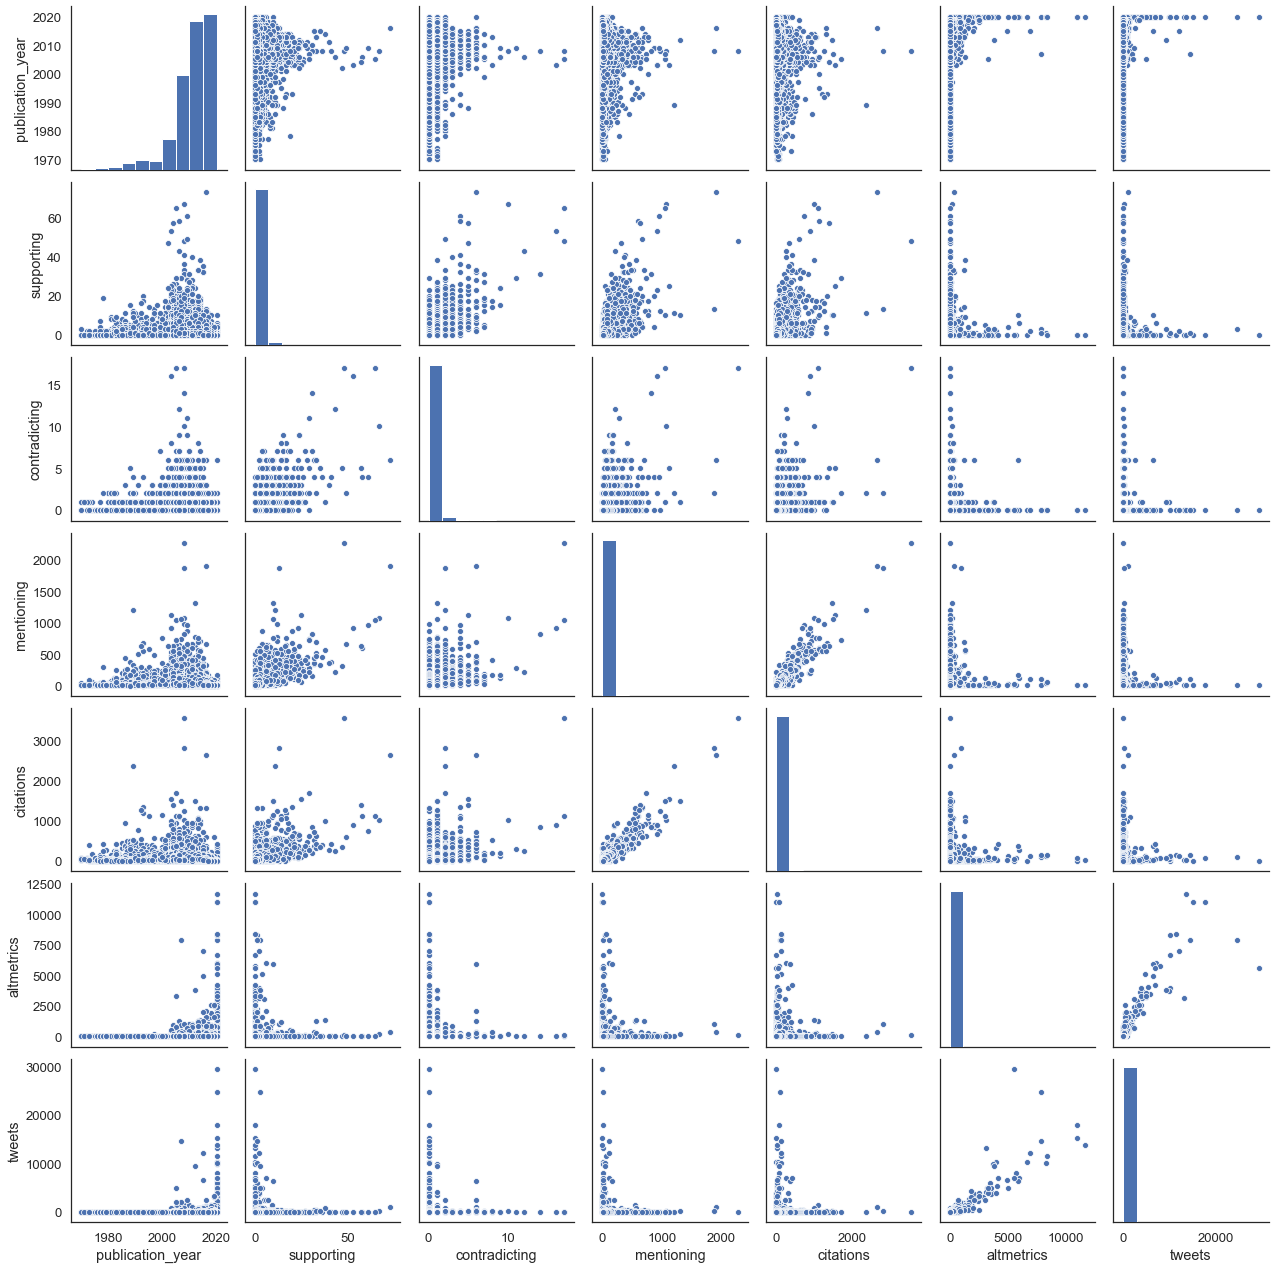

In [92]:
sns.pairplot(df_join[["publication_year","supporting","contradicting","mentioning","citations","altmetrics","tweets"]]);

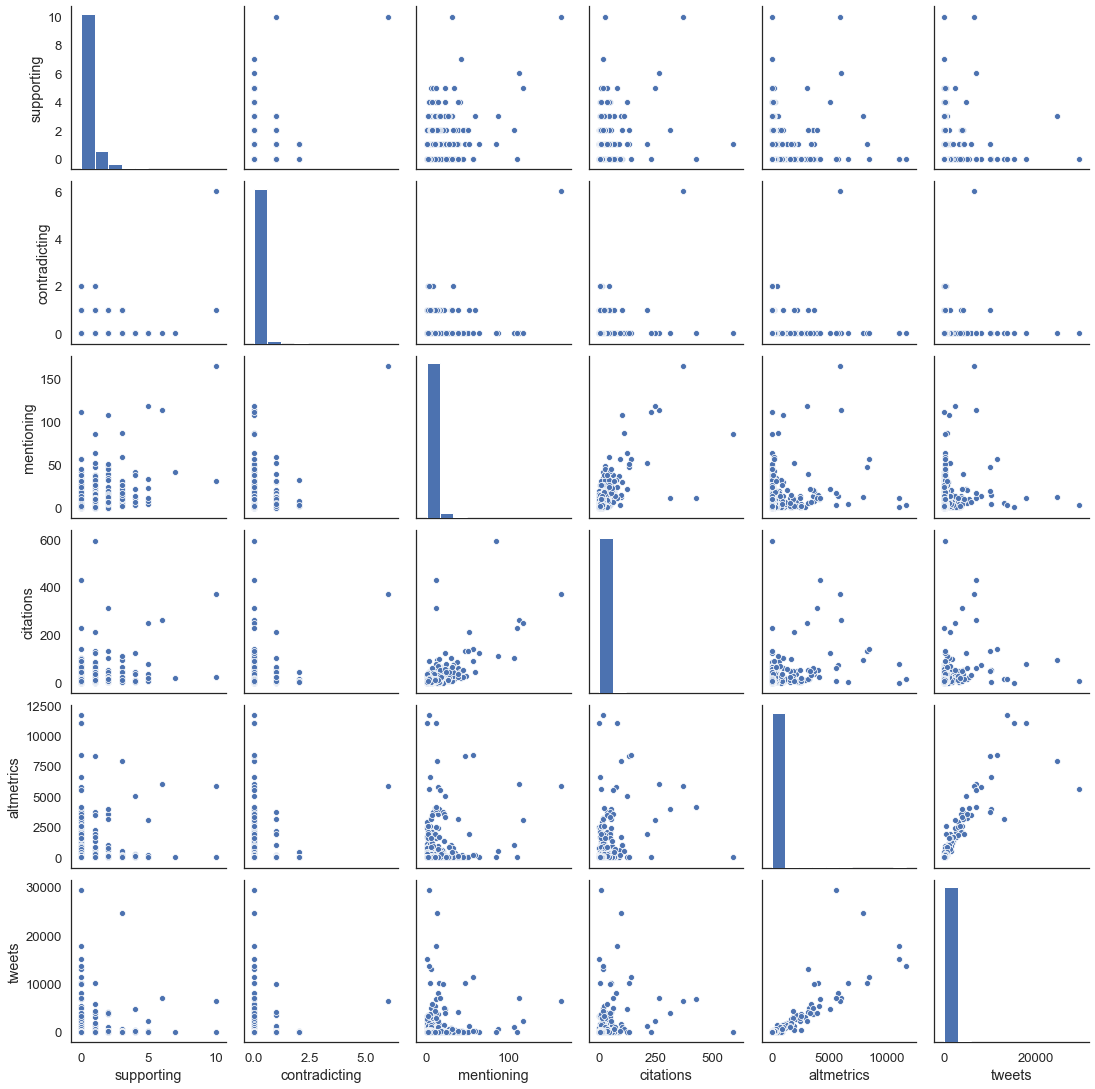

In [93]:
sns.pairplot(df_join[df_join.publication_year>2017][["supporting","contradicting","mentioning","citations","altmetrics","tweets"]]);

In [94]:
df_join.sort_values("contradicting",ascending=False)

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,total,supporting,contradicting,mentioning,unclassified,citations,altmetrics,tweets
15214,26477,Cloning of a human parvovirus by molecular scr...,The identification of new virus species is a k...,2005.0,8.0,Proceedings of the National Academy of Sciences,NaN,NaN,NaN,10.1073/pnas.0504666102,16118271.0,PMC1200281,1128,65,17,1046,0,1106,15.000,0
19223,33669,Epidemiology and causes of preterm birth,Summary This paper is the first in a three-par...,2008.0,1.0,The Lancet,NaN,NaN,NaN,10.1016/s0140-6736(08)60074-4,18177778.0,NaN,2337,48,17,2272,0,3545,69.416,3
19110,33483,Clinical progression and viral load in a commu...,Summary Background We investigated the tempora...,2003.0,5.0,The Lancet,NaN,NaN,NaN,10.1016/s0140-6736(03)13412-5,12781535.0,NaN,983,53,16,914,0,902,54.030,17
13370,24424,IL-22 mediates mucosal host defense against Gr...,Emerging evidence supports the concept that T ...,2008.0,2.0,Nature Medicine,NaN,NaN,NaN,10.1038/nm1710,18264110.0,PMC2901867,871,31,14,826,0,844,10.000,0
24406,41256,Evidence of human coronavirus HKU1 and human b...,Abstract Undiagnosed cases of respiratory trac...,2006.0,1.0,Journal of Clinical Virology,NaN,NaN,NaN,10.1016/j.jcv.2005.09.008,16257260.0,NaN,270,43,12,215,0,254,7.750,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9386,16590,A new prokaryotic expression vector for the ex...,BACKGROUND: Despite the growing demand for ant...,2019.0,2.0,BMC Biotechnol,NaN,NaN,NaN,10.1186/s12896-019-0506-x,30770741.0,PMC6377777,2,0,0,2,0,3,0.500,2
9385,16587,Camouflage and interception: how pathogens eva...,Intracellular DNA and RNA sensors play a vital...,2018.0,12.0,Immunology,NaN,NaN,NaN,10.1111/imm.13030,30499584.0,PMC6376273,2,0,0,2,0,3,6.550,11
9384,16584,Determination of host proteins composing the m...,Positive-sense RNA viruses hijack intracellula...,2019.0,1.0,NaN,NaN,NaN,NaN,10.7554/elife.42037,30632963.0,PMC6372286,3,0,0,3,0,6,15.850,25
9383,16583,Pathogen diversity drives the evolution of gen...,Central players of the adaptive immune system ...,2019.0,1.0,PLoS Biol,NaN,NaN,NaN,10.1371/journal.pbio.3000131,30703088.0,PMC6372212,2,0,0,2,0,9,44.800,114
